#2. Analysis of Phone Reviews

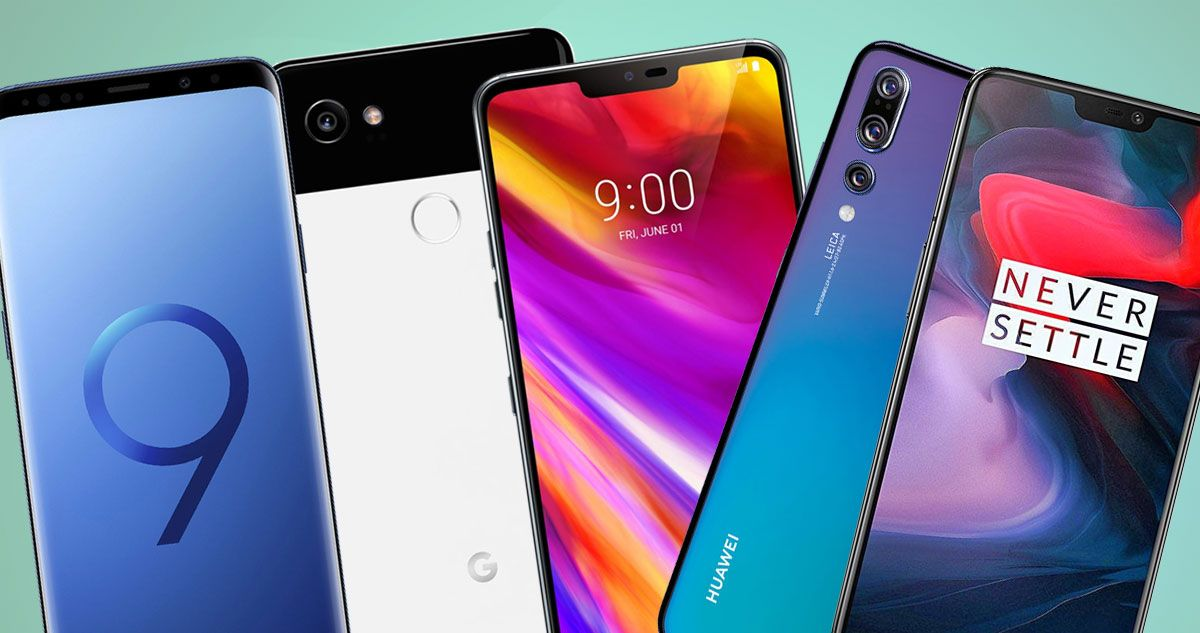

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img= cv2.imread('/content/drive/My Drive/phn.jpg') 
cv2_imshow(img) 

We are provided with above 4700 reviews of 22 different mobile phones. The aim, on a broad level:
* To analyse these phones based on the reviews
* Dimension reduction through TSNE plot
* Extract features and associate these features for different brands of phones


## Import packages and Data

The necessary packages for data exploration and the csv file containing the phone reviews is read in. We perform an initial data exploration to get a hold of the review file.

In [ ]:
pip install vaderSentiment

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import RegexpTokenizer, word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import nltk

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
phn_data= pd.read_csv(r"/content/drive/My Drive/Phone Reviews.csv", encoding= "iso-8859-1")
df_org= phn_data
phn_data.head(3)

,label,Star Rating,Sentences
0,Galaxy Core,5,09 JULY 13\n \n CERTIFIED BUYER\n ...
1,Galaxy Core,5,A GREAT MODEL BY SAMSUNG FOR YOUNGSTERS. THIS ...
2,Galaxy Core,5,"AM USING THIS FONE SINCE 6 MONTHS,IT RUNS SO F..."


## Data Exploration

We perform a basic data exploration, before delving into text mining.

In [ ]:
print(" The size of the dataset: ", phn_data.shape)

 The size of the dataset:  (4710, 3)


There are about 4710 reviews. The columns contain the name of the phone, their respective ratings and the review comments.

The name of the brands and the number of unique brands available

In [ ]:
print("The name of brands whose reviews are given are: \n",phn_data.label.unique(), "\n and there are ",
      phn_data.label.nunique(), "brands" )

The name of brands whose reviews are given are: 
 ['Galaxy Core' 'Galaxy Grand' 'Galaxy Note' 'Galaxy S Advance'
 'Galaxy S Duos' 'Galaxy S3' 'HTC One V T320' 'HTC One X E720' 'IPhone 5S'
 'Micromax Canvas 4 A210' 'Micromax Canvas HD A116'
 'Micromax Canvas Turbo A250' 'Moto G' 'Nokia Lumia 520' 'Nokia Lumia 620'
 'Nokia Lumia 720' 'Nokia Lumia 920' 'Xperia C' 'Xperia J' 'Xperia P'
 'Xperia U' 'Xperia Z'] 
 and there are  22 brands


## Popularity of Brands

In [ ]:
print("Availability of review for each brand: \n", phn_data.label.value_counts().head(n=10))

Availability of review for each brand: 
 Moto G                        339
Galaxy S Duos                 321
Galaxy Grand                  296
Micromax Canvas HD A116       277
Galaxy Core                   259
Micromax Canvas 4 A210        253
Xperia U                      251
Nokia Lumia 520               240
Micromax Canvas Turbo A250    239
Nokia Lumia 620               227
Name: label, dtype: int64


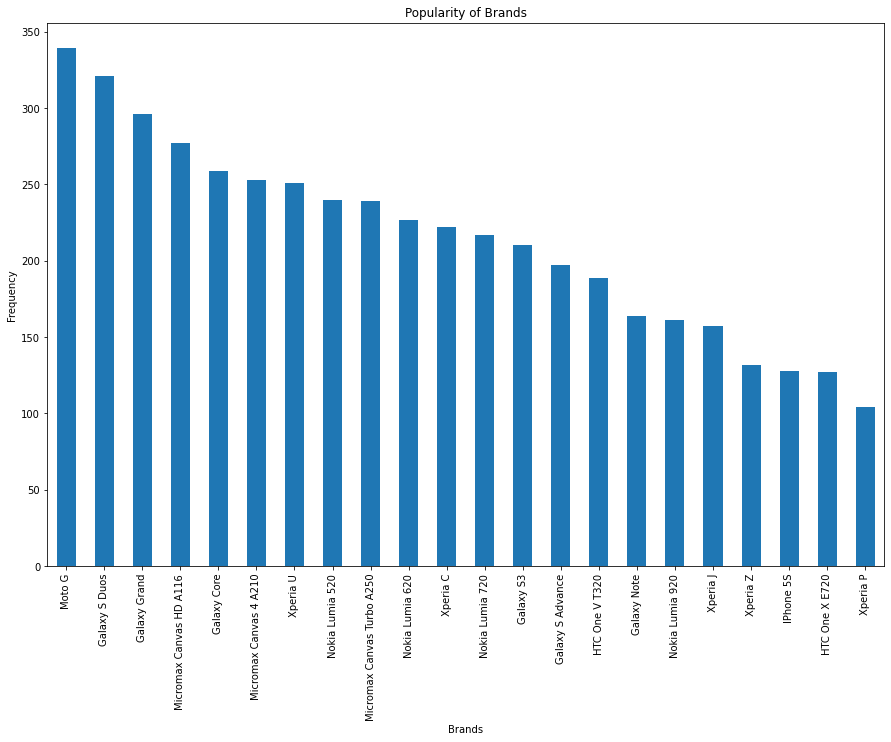

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10));
phn_data["label"].value_counts().plot(kind= 'bar');
plt.xlabel('Brands');
plt.ylabel('Frequency');
plt.title("Popularity of Brands");

### Distribution of ratings

In [ ]:
print("The weightage of ratings:\n", phn_data["Star Rating"].value_counts())

The weightage of ratings:
 5    1585
4    1227
1     785
3     699
2     414
Name: Star Rating, dtype: int64


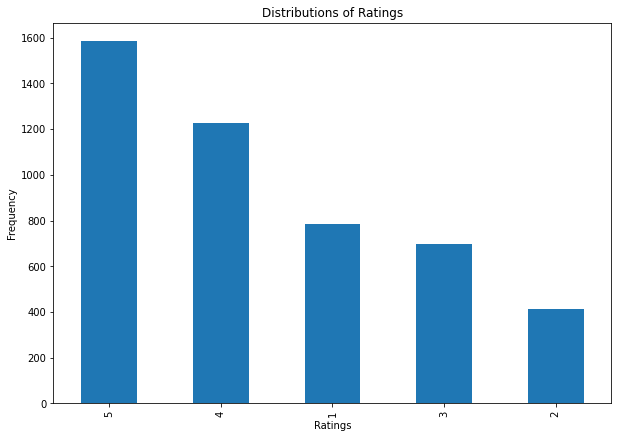

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7));
phn_data["Star Rating"].value_counts().plot(kind= 'bar');
plt.xlabel('Ratings');
plt.ylabel('Frequency');
plt.title("Distributions of Ratings");

A view of the ratings' distribution for each phone

In [ ]:
data_nosent= phn_data[['label','Star Rating']]
data_nosent['count']= 1
data_nosent.groupby(['label','Star Rating']).count().head(6)

count
label        Star Rating       
Galaxy Core  1               42
             2               23
             3               54
             4               70
             5               70
Galaxy Grand 1               58

## Sentiment of reviews

To classify the reviews as 'positive' or 'negative', based on ratings.

A rating >= 3 is 'positive', else 'negative'.

In [ ]:
phn_data['Score']= ['positive' if x>= 3 else 'negative' for x in phn_data['Star Rating'] ]

In [ ]:
print("Total number of positive reviews: ",phn_data[phn_data.Score== 'positive'].shape )
print("Total number of negative reviews: ",phn_data[phn_data.Score== 'negative'].shape )

Total number of positive reviews:  (3511, 4)
Total number of negative reviews:  (1199, 4)


## Text Mining

We now look into the 'Sentences' column, which seemingly contains the reviews provided by the buyers of the specific phones.

In [ ]:
print("Viewing a sample of the phone reviews: \n", phn_data.Sentences.head(3) )

Viewing a sample of the phone reviews: 
 0    09 JULY 13\n      \n      CERTIFIED BUYER\n   ...
1    A GREAT MODEL BY SAMSUNG FOR YOUNGSTERS. THIS ...
2    AM USING THIS FONE SINCE 6 MONTHS,IT RUNS SO F...
Name: Sentences, dtype: object


From above, we see that the reviews are not well arranged; for some, the review is in the next line, with unnecessary spaces in many. So, before analysis, we need to clean the data.

### Text Cleaning

Performing preliminary text cleaning tasks, which mainly comprises of cleaning the reviews of spaces, tabs and next line print.
This is done to make the data consistent.

In [ ]:
phn_data.Sentences= [" ".join(sent.split()) for sent in phn_data.Sentences]

In [ ]:
phn_data.Sentences.replace(to_replace = "\n",value= "", regex= True, inplace= True)
phn_data.Sentences.replace(to_replace = ["\.", "\.,"],value= "", regex = True, inplace = True)
phn_data.Sentences.replace(to_replace = ["\?", "\?.", "\:", "\(", "\)", "\@", "\!", "\_", ","],value= "", regex= True, inplace= True)

In [ ]:
print(" TO verify if cleaning is done as expected: \n", phn_data.Sentences[100] )

 TO verify if cleaning is done as expected: 
 I AM FULLY SATISFIED WITH THIS PRODUCT AS MY BUDGET EASY ACCESSIBLY IS THE BEST SPECIALITY FOR THIS PRODUCT I FELT THE BAD IMPRESSION IS THAT THE PERFORMANCE OF THE HEAD PHONE SOUND AND THE CAPACITY OF BATTERY OTHER WISE THIS IS VERY GOOD AND I SUGGEST EVERYBODY FLIP CART IS VERY BEST ONLINE SHOPPING SITE AND THEIR SERVICE IS VERY GOOD ONLY THE SUGGESTION FROM ME IS THAT PLEASE RE-ORGANISE YOUR CUSTOMER CARE THERE IS NO PROPER ANSWER GET US FROM THEIR SIDE AND ALSO PLEASE MENTION THE PHONE NUMBER OF EKART HUBS OF MAJOR CITIES THAT WILL HELP THE CUSTOMER TO CLARIFY THE DESPATCH OF THE PRODUCT ANILKUMAR COIMBATORE


### Word Correction

Before proceeding further, we'll clean the reviews of incorrect english, ie, of slang

In [ ]:
import csv
def slang_trans(sent):
    user_string = sent.split(" ")
    #print(user_string)
    j = 0
    for i in user_string:
        with open('/content/drive/My Drive/slang.txt', 'r') as slang_file:
            data = csv.reader(slang_file, delimiter="=")
            i = re.sub('[^a-zA-Z0-9-_]', '', i)
            for row in data:
                if i.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
        slang_file.close()
        j = j + 1
    
    #print(' '.join(user_string))
    return(' '.join(user_string))

In [ ]:
no_slang= []
for sn in phn_data.Sentences:
  no_slang.append(slang_trans(sn))

In [ ]:
phn_data.Sentences= pd.Series(no_slang)
phn_data.Sentences= phn_data.Sentences.str.lower()
phn_data.head()

,label,Star Rating,Sentences,Score
0,Galaxy Core,5,09 july 13 certified buyer shocked by low revi...,positive
1,Galaxy Core,5,a great model by samsung for youngsters this i...,positive
2,Galaxy Core,5,am using this phone since 6 monthsit runs so ...,positive
3,Galaxy Core,5,as i thought about it i got all that in it ama...,positive
4,Galaxy Core,5,battery back up is good it comes around one an...,positive


We tokenize the reviews for further analysis.

In [ ]:
tokenizer= RegexpTokenizer("[a-zA-Z0-9’'(\d.\d)]+")
tokens= [tokenizer.tokenize(x.lower()) for x in phn_data['Sentences']]

Now we remove the stopwords, so that only the important tokens are present.

In [ ]:
# removing stopwords
tokens_no_stopwords= [token for x in tokens for token in x if token not in STOPWORDS]
tokens_no_stopwords[0: 10]

['09',
 'july',
 '13',
 'certified',
 'buyer',
 'shocked',
 'low',
 'reviews',
 'good',
 'phone']

We count the most common words, across the reviews.

In [ ]:
word_count= Counter(tokens_no_stopwords)
word_count.most_common(10)

[('phone', 9824),
 ('good', 4280),
 ('camera', 2562),
 ('battery', 2328),
 ('one', 2299),
 ('2', 2082),
 ('will', 2016),
 ('screen', 1798),
 ('samsung', 1757),
 ('quality', 1611)]

Here we see that phone is the most common, which is quite expected, as these are phone reviews. So, we add such words to the stopwords dictionary, so that it is not considered.

In [ ]:
## Adding new stopwords to existing list
#stopwords= STOPWORDS.copy()
new_stpwrds= ["phone", "phones", 'will', 'even', 'buy', "gets", "gt"] 
[STOPWORDS.add(n) for n in new_stpwrds]
# removing as per the new stopwords
tokens_no_stopwords= [token for x in tokens for token in x if token not in STOPWORDS]
word_count= Counter(tokens_no_stopwords)
word_count.most_common(10)

[('good', 4280),
 ('camera', 2562),
 ('battery', 2328),
 ('one', 2299),
 ('2', 2082),
 ('screen', 1798),
 ('samsung', 1757),
 ('quality', 1611),
 ('flipkart', 1581),
 ('1', 1536)]

We create a dataframe of the 200 most common words

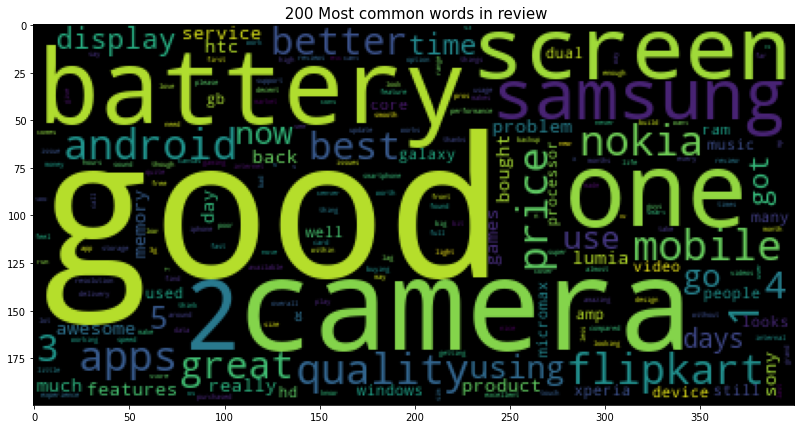

In [ ]:
rvw_cmn= dict(word_count.most_common(200))
wc= WordCloud()
wc.generate_from_frequencies(rvw_cmn);
plt.subplots(figsize= (15, 7));
plt.imshow(wc);
plt.title(" 200 Most common words in review", fontdict= {'fontsize': 15});

We see that, most of the phone have been reviewed as "good", with a few reviews having "best" and "great" also. Mostly, the "camera" and "battery" of the phone has been talked about.

The phones have been purchased from "flipkart", as it appears frequently, suggesting people talked about the delivery of this website.

### Stemming

In [ ]:
from nltk.stem.snowball import SnowballStemmer
st= SnowballStemmer('english')
stmm= []
for tk in set(tokens_no_stopwords):
  stmm.append(st.stem(tk))

In [ ]:
Counter(stmm).most_common(10)

[('featur', 7),
 ('use', 7),
 ('expect', 6),
 ('compar', 6),
 ('connect', 6),
 ('produc', 6),
 ('order', 5),
 ('review', 5),
 ('one', 5),
 ('thank', 5)]

But stemming doesn't seem to help much, as it mostly changes the spelling incorrectly, here.

In [ ]:
phn_data.head(3)

,label,Star Rating,Sentences,Score
0,Galaxy Core,5,09 july 13 certified buyer shocked by low revi...,positive
1,Galaxy Core,5,a great model by samsung for youngsters this i...,positive
2,Galaxy Core,5,am using this phone since 6 monthsit runs so ...,positive


In [ ]:
all_pos=[]
all_neg= []
i= 0
for s in phn_data.Sentences:
  for w in s.split():
    if(phn_data.Score.values)[i]== 'positive':
      all_pos.append(w)
    else:
      all_neg.append(w)
  i= i+1

In [ ]:
print("Most Common Positive Words :\n ")
nltk.FreqDist(all_pos).most_common(20)

Most Common Positive Words :
 


[('the', 16107),
 ('is', 11490),
 ('and', 10066),
 ('i', 8666),
 ('a', 8331),
 ('to', 8177),
 ('phone', 7246),
 ('it', 7241),
 ('for', 6042),
 ('of', 5979),
 ('this', 5868),
 ('in', 5439),
 ('you', 4708),
 ('with', 4612),
 ('good', 3613),
 ('not', 3397),
 ('but', 3269),
 ('on', 3024),
 ('have', 2765),
 ('are', 2645)]

In [ ]:
print("Most Common Negative Words :\n ")
nltk.FreqDist(all_neg).most_common(20)

Most Common Negative Words :
 


[('the', 4992),
 ('i', 3436),
 ('to', 3295),
 ('is', 3127),
 ('and', 3021),
 ('phone', 2519),
 ('a', 2394),
 ('it', 2287),
 ('this', 2131),
 ('of', 1949),
 ('for', 1865),
 ('in', 1704),
 ('not', 1610),
 ('you', 1589),
 ('on', 1095),
 ('with', 1080),
 ('but', 1080),
 ('have', 1049),
 ('that', 958),
 ('my', 917)]

### Sentiment Analysis using Vader

In [ ]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
      
    '''
    print("Overall sentiment dictionary is : ", sentiment_dict) 
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
    print("Sentence Overall Rated As", end = " ")
    '''
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        #print("Positive") 
        sentiment_dict['overall']= 'positive'
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        #print("Negative")
        sentiment_dict['overall']= 'negative' 
  
    else : 
        #print("Neutral")
        sentiment_dict['overall']= 'neutral'
    return(sentiment_dict)

In [ ]:
sentiment= pd.DataFrame()
for s in phn_data.Sentences:
  sentiment= sentiment.append(sentiment_scores(s), ignore_index= True)

In [ ]:
sentiment.tail()

,compound,neg,neu,overall,pos
4705,0.7895,0.052,0.865,positive,0.082
4706,-0.3448,0.071,0.890,negative,0.040
4707,0.7212,0.064,0.797,positive,0.139
4708,-0.5407,0.128,0.766,negative,0.106
4709,0.7537,0.055,0.774,positive,0.172


The sentiment of reviews:
  positive    3753
negative     833
neutral      124
Name: overall, dtype: int64


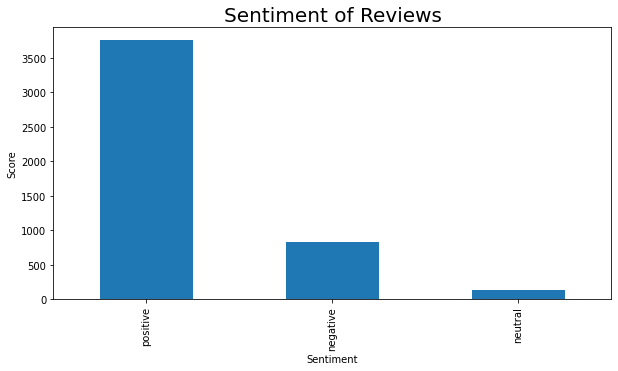

In [ ]:
print("The sentiment of reviews:\n ", sentiment.overall.value_counts())
plt.figure(figsize= (10, 5))
sentiment.overall.value_counts().plot(kind= 'bar')
plt.xlabel("Sentiment")
plt.ylabel("Score")
plt.title("Sentiment of Reviews", fontdict= {'fontsize': '20'} )
plt.show()

In [ ]:
phn_data= pd.concat([phn_data, sentiment.overall], axis= 1)
phn_data.head()

,label,Star Rating,Sentences,Score,overall
0,Galaxy Core,5,09 july 13 certified buyer shocked by low revi...,positive,positive
1,Galaxy Core,5,a great model by samsung for youngsters this i...,positive,positive
2,Galaxy Core,5,am using this phone since 6 monthsit runs so ...,positive,positive
3,Galaxy Core,5,as i thought about it i got all that in it ama...,positive,positive
4,Galaxy Core,5,battery back up is good it comes around one an...,positive,positive


### TSNE Plot

#### TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df= 10)
final_tf_idf = tf_idf_vect.fit_transform(phn_data.Sentences.values)

In [ ]:
std_tfidf = StandardScaler(with_mean = False)
std_data_tfidf = std_tfidf.fit_transform(final_tf_idf)
std_data_tfidf = std_data_tfidf.todense()

In [ ]:
print("The shape of the standardized data: \n", std_data_tfidf.shape)

The shape of the standardized data: 
 (4710, 9782)


In [ ]:
model = TSNE(n_components = 2, perplexity = 50)
tsne_tfidf = model.fit_transform(std_data_tfidf)

In [ ]:
tsne_tfidf_cp= tsne_tfidf

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


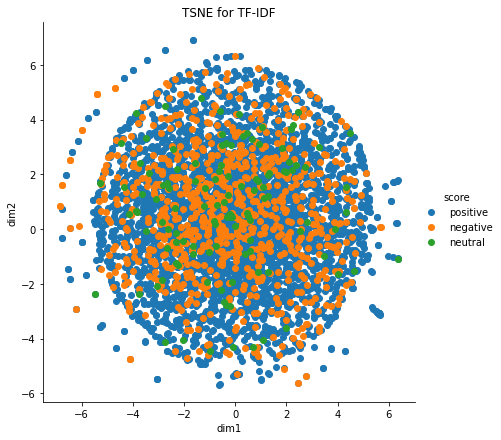

In [ ]:
tsne_tfidf = np.vstack((tsne_tfidf.T, phn_data.overall)).T
tsne_df = pd.DataFrame(data = tsne_tfidf, columns = ("dim1", "dim2", "score"))
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

We still don't get a clear sparation between the classes.

In [ ]:
features_tfidf = tf_idf_vect.get_feature_names()
len(features_tfidf)

9782

In [ ]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
## Get top n tfidf values in row and return them with their corresponding feature names.
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0], features_tfidf,25)

In [ ]:
top_tfidf[0: 10]

,feature,tfidf
0,sound,0.281349
1,talking about,0.243180
2,talking,0.214420
3,he is,0.141493
4,don find,0.141493
5,low cost,0.139869
6,somebody,0.138365
7,mobile then,0.138365
8,issues in,0.138365
9,you open,0.136965


#### Word2Vec

To generate vector representations of words that carry semantic meanings for further NLP tasks. 
The reason for this transformation is so that machine learning algorithm can perform linear algebra operations on numbers (in vectors) instead of words.

In [ ]:
# Train your own Word2Vec model using your own text corpus
import gensim
sent_list = []
for sent in phn_data.Sentences.values:
    filt_sent = []
    for w in sent.split():
        for c in w.split():
            if(c.isalpha()):    
                filt_sent.append(c.lower())
            else:
                continue 
    sent_list.append(filt_sent)

In [ ]:
print(phn_data.Sentences.values[0])
print("*****************************************************************")
print(sent_list[0])

09 july 13 certified buyer shocked by low reviews it is a very good phone almost all expert reviews says it i don't understand why people compare it to other while writing reviews focus on the phone's performance 1 12 ghz dual core gives good performance even in high quality games 2 1gb ram is a good deal when it comes to gaming and running applications 3 screen size is good lower than grand but high than s duos 4 good gpu and screen resolution even plays temple run 2 without lag 5 5mp camera is also good people who say its very low excuse please if you want to take professional quality photos have a camera still photo quality is very nice 6 interface is good 7 android jelly bean 41 is amazing 8 have accelerometer and compass 9 phone turns off screen when user is not viewing it thus saves battery 10 1800 mah battery is better than nokia lumia's 1300 mah even 11 front camera also there i have found the phone good but if you want more spend some more bucks and buy and samsung galaxy s4 a

In [ ]:
w2v_model=gensim.models.Word2Vec(sent_list,min_count=5,size=50, workers=4)  

In [ ]:
w2v = w2v_model[w2v_model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
w2v.shape

(4345, 50)

In [ ]:
words = list(w2v_model.wv.vocab)
print(len(words))

4345


In [ ]:
w2v_model.wv.most_similar('good')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('decent', 0.8389115929603577),
 ('nice', 0.8319011926651001),
 ('great', 0.8176623582839966),
 ('ok', 0.8090105652809143),
 ('bad', 0.7857680916786194),
 ('cool', 0.7798027992248535),
 ('superb', 0.7759395837783813),
 ('poor', 0.761846661567688),
 ('big', 0.7562252283096313),
 ('pretty', 0.7433651089668274)]

#### Text Avg W2V

In [ ]:
##Avg W2V
from tqdm import tqdm
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

  0%|          | 0/4710 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
100%|██████████| 4710/4710 [00:03<00:00, 1333.80it/s]

4710
50


In [ ]:
#TFIDF weighted W2v¶
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(phn_data.Sentences)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

  0%|          | 0/4710 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 4710/4710 [00:03<00:00, 1376.10it/s]


In [ ]:
std_data2 = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)
print(std_data2.shape)
type(std_data2)
type(std_data2)

(4710, 50)


numpy.ndarray

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'AVG W2V')

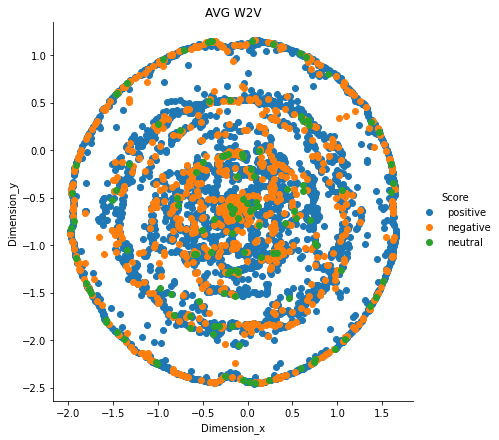

In [ ]:
model = TSNE(n_components=2, perplexity=30, learning_rate=600, n_iter=500)

for_tsne = model.fit_transform(std_data2)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .todense() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, phn_data.overall)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("AVG W2V")

#### Text TFIDF on weighted W2V

In [ ]:
std_data3 = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)
print(std_data3.shape)
type(std_data3)
type(std_data3)

(4710, 50)


numpy.ndarray

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Weighted W2V')

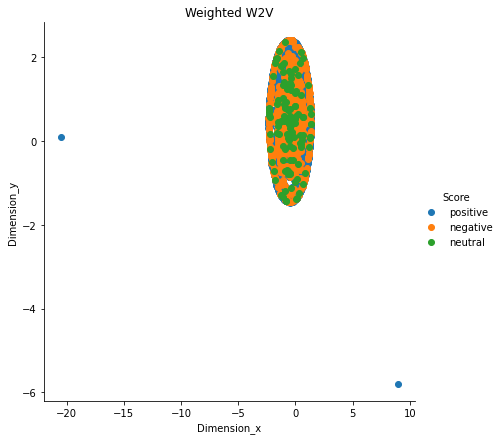

In [ ]:
model = TSNE(n_components=2, perplexity=40, learning_rate=600, n_iter=500)

for_tsne = model.fit_transform(std_data3)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .todense() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, phn_data.overall)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("Weighted W2V")

Conclusions:-

* None of TSNE representation gives a well separated reviews.

* We can not simply draw a plane to separate the reviews. Although, by looking at only visual representation of data we can not take decision whether to draw a plane or not.
* We will have to find some alternative method by which we'll be able to separate the reviews.